# Deep Learning with fashionMNIST

Since I have been studying the theory behind Deep Learning and Neural Networks for several weeks now, it was time for me to get some hands-on experience One of the classic beginner projects is MNIST dataset containing pictures of hadnwritten digits. However, I was not very excited about this dataset, given how many examples and notebooks I have already seen using it. So I decided to change it up a little bit and use fashionMNIST, a dataset of article images on Zalando. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image and belongs to one of 10 classes. It thus has the exact same properties as the original MNIST dataset.      

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn

## Import Data

fasionMNIST is available on [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist) from which I downloaded and imported it.

In [2]:
train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape, test.shape

((60000, 785), (10000, 785))

## Preprocessing Data

First, I split train.csv into a training and validation set, using `train_test_split` in sci-kit learn.

In [5]:
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

In [6]:
train.shape, val.shape

((48000, 785), (12000, 785))

I then convert the dataframes into tensors in order to handle them with PyTorch.

In [7]:
train_tns = torch.from_numpy(train.values)
val_tns = torch.from_numpy(val.values)
test_tns = torch.from_numpy(test.values)

In [8]:
train_tns.shape, val_tns.shape, test_tns.shape

(torch.Size([48000, 785]), torch.Size([12000, 785]), torch.Size([10000, 785]))

I store the labels in a separate tensor, which leaves me with for two tensors - features and label - for each the training, validation and test set. I also normalize the pixel values, so that they take on values between 0 and 1 in order to make convergence faster.

In [9]:
train_features = train_tns[:, 1:].type(torch.FloatTensor)/255
val_features = val_tns[:, 1:].type(torch.FloatTensor)/255
test_features = train_tns[:, 1:].type(torch.FloatTensor)/255

train_features.shape, val_features.shape, test_features.shape

(torch.Size([48000, 784]), torch.Size([12000, 784]), torch.Size([48000, 784]))

In [10]:
train_labels = train_tns[:, 0]
val_labels = val_tns[:, 0]
test_labels = test_tns[:, 0]
train_labels.shape, val_labels.shape, test_labels.shape

(torch.Size([48000]), torch.Size([12000]), torch.Size([10000]))

## Building the datasets and the dataloader

My `fasionMNISTDataset` class build on top of the torch.utils.data.Dataset class and includes the option to display the image when calling its index by setting `plot=True`.

In [11]:
class fashionMNISTDataset(Dataset):
    
    def __init__(self, features, labels, plot=True):
        self.images = features
        self.labels = labels
        self.plot = plot
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = self.images[idx, :]
        label = self.labels[idx]
        sample = (image, label)
        if self.plot:
            plt.imshow(self.images[idx].reshape(28, 28), cmap='gray')
            plt.title(get_label(self.labels[idx]))
        return sample

In [12]:
def get_label(label):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[i] for i in label]

In [13]:
get_label([1,2,3])

['trouser', 'pullover', 'dress']

I only build a training and test dataset, not a validation dataset, since I will give my `train` function (see further below) `valid_features`and `valid_labels`directly.

In [14]:
train_ds = fashionMNISTDataset(train_features, train_labels, plot=False)
val_ds = fashionMNISTDataset(val_features, val_labels, plot=False)
test_ds = fashionMNISTDataset(test_features, test_labels, plot=False)

With the datasets I can now build a dataloader for both the training set.

In [77]:
batch_size = 250
train_dl = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In order to be able to see the images of a batch, I build the function `show_images` and test it on the first batch in the dataloader.

In [16]:
def show_images(images, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * 1.5, num_rows * 1.5)
    figure, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    figure.tight_layout()
    for i, (ax, images) in enumerate(zip(axes, images)):
        ax.imshow(np.array(images), cmap='gray')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [17]:
X, y = next(iter(train_dl))

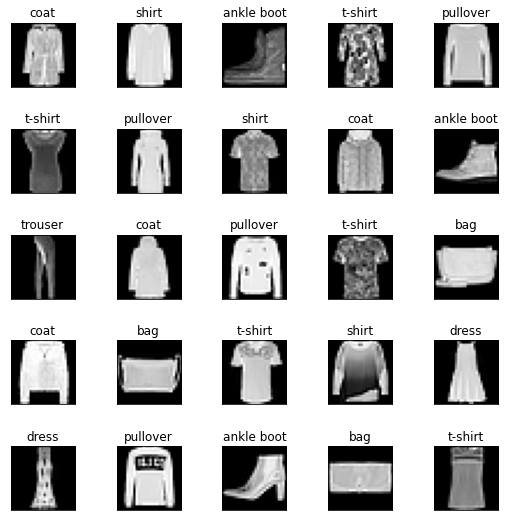

In [18]:
show_images(X.reshape(batch_size, 28,28), 5, 5, titles=get_label(y));

## Building the model

The model serving as my baseline is a simple two fully connected layers using the `nn.Module` class in PyTorch.

In [19]:
class NN_1(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(in_dim, hidden_dim), 
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim))
        
    def forward(self, X):
        return self.net(X)



I use cross-entropy loss as the loss function for this model since the task at hand is a multiclass classification problem.

In [20]:
loss = nn.CrossEntropyLoss()

I then build a `train` function that performs forward and backward propagation and also plots the learning curve.

In [95]:
def train(net, train_dl, val_dl, num_epochs, learning_rate, weight_decay, device):
    
    net = net.to(device)
    net.train()
    
    torch.manual_seed(42)
    
    train_epoch_loss, valid_epoch_loss = [], []
    val_predictions = torch.empty(0,10).cuda()
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    for epoch in range(num_epochs):  
       
        train_batch_loss, valid_batch_loss = [], []
        
        for batch in train_dl:
            
            X_train = batch[0].to(device)
            y_train = batch[1].to(device)
            optimizer.zero_grad()
            preds = net(X_train)
            l = loss(preds, y_train)
            l.backward()
            optimizer.step()
            
            train_batch_loss.append(l.detach().item())
        train_epoch_loss.append(np.mean(train_batch_loss))
        
        if val_dl is not None:
            net.eval()
            with torch.no_grad():
                for batch in val_dl:
                    X_val = batch[0].to(device)
                    y_val = batch[1].to(device)
                    val_preds = net(X_val)
                    if epoch == (num_epochs-1):
                        val_predictions = torch.cat((val_predictions, val_preds), 0)
                    valid_batch_loss.append(loss(val_preds, y_val).detach().item())
                        
            valid_epoch_loss.append(np.mean(valid_batch_loss))
        
        print(f'Ep: {epoch+1}/{num_epochs} | Train Loss: {train_epoch_loss[-1]:.4f} | Val Loss: {valid_epoch_loss[-1]:.4f}')
        
    plot_learning_curve(num_epochs, train_epoch_loss, valid_epoch_loss, 'Loss');
    
    return val_predictions, train_epoch_loss, valid_epoch_loss     

In [22]:
def plot_learning_curve(num_epochs, train_loss, valid_loss, ylabel):
    plt.plot(range(num_epochs), train_loss, label='train loss')
    plt.plot(range(num_epochs), valid_loss, label='valid loss')
    plt.xticks(range(num_epochs), range(1, num_epochs + 1))
    plt.ylabel(ylabel)
    plt.xlabel('Epochs')
    plt.legend()

## Training the model

To see if my model works, I first train it with three epochs.

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [24]:
in_dim, hidden_dim, out_dim = 784, 100, 10

NN_1(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Ep: 1/3 | Train Loss: 0.7896 | Val Loss: 0.5212
Ep: 2/3 | Train Loss: 0.5185 | Val Loss: 0.4608
Ep: 3/3 | Train Loss: 0.4519 | Val Loss: 0.4774


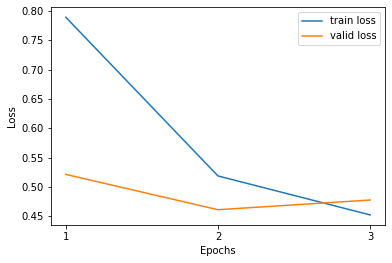

In [90]:
num_epochs = 3
learning_rate = 0.3
weight_decay = 0

net = NN_1(in_dim, hidden_dim, out_dim)
print(net)

preds, train_loss, valid_loss = train(net, train_dl=train_dl, val_dl=val_dl, num_epochs=num_epochs, 
                                      learning_rate=learning_rate, weight_decay=weight_decay, device=device)

Since this looks alright, I now train the model with 30 epochs and a learning rate of 0.1.

NN_1(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Ep: 1/30 | Train Loss: 0.9435 | Val Loss: 0.6906
Ep: 2/30 | Train Loss: 0.6048 | Val Loss: 0.5443
Ep: 3/30 | Train Loss: 0.5295 | Val Loss: 0.5487
Ep: 4/30 | Train Loss: 0.4960 | Val Loss: 0.4647
Ep: 5/30 | Train Loss: 0.4742 | Val Loss: 0.4511
Ep: 6/30 | Train Loss: 0.4508 | Val Loss: 0.4378
Ep: 7/30 | Train Loss: 0.4351 | Val Loss: 0.4249
Ep: 8/30 | Train Loss: 0.4256 | Val Loss: 0.4084
Ep: 9/30 | Train Loss: 0.4132 | Val Loss: 0.4090
Ep: 10/30 | Train Loss: 0.4038 | Val Loss: 0.4114
Ep: 11/30 | Train Loss: 0.3960 | Val Loss: 0.4025
Ep: 12/30 | Train Loss: 0.3887 | Val Loss: 0.4067
Ep: 13/30 | Train Loss: 0.3792 | Val Loss: 0.3989
Ep: 14/30 | Train Loss: 0.3706 | Val Loss: 0.3772
Ep: 15/30 | Train Loss: 0.3666 | Val Loss: 0.3673
Ep: 16/30 | Train Loss: 0.3596 | Val Loss: 0.3651
Ep: 17/30 | Train Loss: 0.3544 | Val 

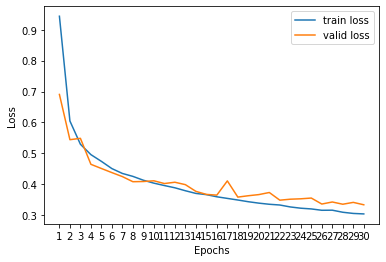

In [97]:
num_epochs = 30
learning_rate = 0.1
weight_decay = 0

net = NN_1(in_dim, hidden_dim, out_dim)
print(net)

preds, train_loss, valid_loss = train(net, train_dl=train_dl, val_dl=val_dl, num_epochs=num_epochs, 
                                      learning_rate=learning_rate, weight_decay=weight_decay, device=device)

# Model interpretation

To see where the model has its idfficulties predicting certain images, I build a confusion matrix.

In [98]:
def fn_confusion_matrix(y, preds):
    y_arr = y.numpy()
    preds = preds.to('cpu')
    preds_arr = np.array(preds)
    preds_arr_idx = np.argmax(preds_arr, axis=1)
    
    cm = confusion_matrix(y_arr, preds_arr_idx)
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    df_cm = pd.DataFrame(cm, 
                     index=[i for i in text_labels], 
                     columns = [i for i in text_labels])
    
    return sn.heatmap(df_cm, annot=True, cmap='Reds')

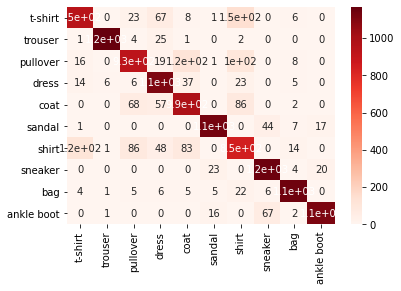

In [99]:
fn_confusion_matrix(val_ds.labels, preds);

It seems like the model often confuses pieces of clothing that are quite similar, e.g. shirts with t-shirts, pullovers and coats, and ankle boot with sneakers.

To be continued...